These notebook is used for initial training. Only necessary preprocessing is done, mainly categorical features encoding and Nans replacement. 
It should show the main problems with observations, show main model difficulties, and feaures importances. It should also guide the way of validation  Therefore we have:
- data preparation
- cross-validation and modeling
- features and error analysis

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold

import mlflow

import IPython.display as ipd
import seaborn as sns
import matplotlib.pylab as plt

In [2]:
data = pd.read_csv(os.path.join('..', 'data', 'raw', 'ubaar-competition', 'train.csv'), encoding="utf-8", index_col="ID")

In [3]:
data['distanceKM'].fillna(data['distanceKM'].median(), inplace=True)
data['taxiDurationMin'].fillna(data['taxiDurationMin'].median(), inplace=True)

In [4]:
data.head()

,date,sourceLatitude,sourceLongitude,SourceState,destinationLatitude,destinationLongitude,destinationState,distanceKM,taxiDurationMin,vehicleType,vehicleOption,weight,price
ID,,,,,,,,,,,,,
88142929797,960218,36.666045,48.489706,زنجان,29.600574,52.537114,فارس,1092.0,751.0,treili,kafi,20.00,15300000
30842979862,960511,32.323951,50.855412,چهارمحال و بختیاری,34.644923,50.876092,قم,414.0,264.0,khavar,mosaghaf_felezi,2.50,1800000
54262798716,960602,32.575448,51.581011,اصفهان,31.819508,49.865235,خوزستان,310.0,292.0,joft,kompressi,14.97,3742000
64071173752,960319,35.029685,48.085763,کردستان,35.703801,51.398824,تهران,391.0,271.0,khavar,mosaghaf_felezi,2.50,1300000
68088966447,960609,31.586965,54.449607,یزد,36.730367,53.965480,گلستان,756.0,573.0,joft,bari,15.00,8870000


In [5]:
data.columns

Index(['date', 'sourceLatitude', 'sourceLongitude', 'SourceState',
       'destinationLatitude', 'destinationLongitude', 'destinationState',
       'distanceKM', 'taxiDurationMin', 'vehicleType', 'vehicleOption',
       'weight', 'price'],
      dtype='object')

In [6]:
columns_countinous = ['date', 'sourceLatitude', 'sourceLongitude', 'destinationLatitude', 'destinationLongitude', 'distanceKM', 'taxiDurationMin', 'weight']
columns_cat = ['vehicleType', 'vehicleOption']

In [7]:
data_oh = pd.get_dummies(data, columns=columns_cat, drop_first=True)
data_oh = data_oh.drop(columns=['SourceState', 'destinationState'])

In [8]:
data_oh.head()

,date,sourceLatitude,sourceLongitude,destinationLatitude,destinationLongitude,distanceKM,taxiDurationMin,weight,price,vehicleType_khavar,vehicleType_tak,vehicleType_treili,vehicleOption_hichkodam,vehicleOption_kafi,vehicleOption_kompressi,vehicleOption_labehdar,vehicleOption_mosaghaf_chadori,vehicleOption_mosaghaf_felezi,vehicleOption_transit_chadori,vehicleOption_yakhchali
ID,,,,,,,,,,,,,,,,,,,,
88142929797,960218,36.666045,48.489706,29.600574,52.537114,1092.0,751.0,20.00,15300000,0,0,1,0,1,0,0,0,0,0,0
30842979862,960511,32.323951,50.855412,34.644923,50.876092,414.0,264.0,2.50,1800000,1,0,0,0,0,0,0,0,1,0,0
54262798716,960602,32.575448,51.581011,31.819508,49.865235,310.0,292.0,14.97,3742000,0,0,0,0,0,1,0,0,0,0,0
64071173752,960319,35.029685,48.085763,35.703801,51.398824,391.0,271.0,2.50,1300000,1,0,0,0,0,0,0,0,1,0,0
68088966447,960609,31.586965,54.449607,36.730367,53.965480,756.0,573.0,15.00,8870000,0,0,0,0,0,0,0,0,0,0,0


In [9]:
features_columns = data_oh.columns[data_oh.columns  != 'price'].values

In [10]:
remote_server_uri = "http://18.185.244.61:5050"
mlflow.set_tracking_uri(remote_server_uri)
mlflow.set_experiment("UbaarCVinitial")
mlflow.start_run(run_name='')
mlflow.log_param('features', features_columns)


y_full = data_oh['price'].values
x_full = data_oh[features_columns].values

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

train_mapes = []
dev_mapes = []
dev_preds = []
dev_refs = []
dev_inds = []

for train_ind, dev_ind in kfold.split(x_full):
    
    model = RandomForestRegressor(n_estimators=20, max_depth=None, min_samples_leaf=8, random_state=42)
#     model = Ridge(alpha=10, solver='auto')
    mlflow.log_param('features', features_columns)
    mlflow.log_param('model', model.__dict__)

    x_train = x_full[train_ind]
    y_train = y_full[train_ind]
    x_dev = x_full[dev_ind]
    y_dev = y_full[dev_ind]
    
#     scaler = StandardScaler()
#     scaler.fit(x_train)
#     x_train = scaler.transform(x_train)
#     x_dev = scaler.transform(x_dev)

    model.fit(x_train, y_train)

    preds_train = model.predict(x_train)
    preds_dev = model.predict(x_dev)

    train_mape = mean_absolute_percentage_error(y_train, preds_train)
    dev_mape = mean_absolute_percentage_error(y_dev, preds_dev)
    
    train_mapes.append(train_mape)
    dev_mapes.append(dev_mape)
    
    dev_preds.extend(list(preds_dev))
    dev_refs.extend(list(y_dev))
    dev_inds.extend(list(dev_ind))
    
    print(f"Train MAPE: {train_mape}")
    print(f"Dev MAPE: {dev_mape}")

print("================")
print(f"Mean MAPE: {np.mean(dev_mapes)}")
print(f"Std MAPE: {np.std(dev_mapes)}")

mlflow.log_metric("Mean dev MAPE", np.mean(dev_mapes))
mlflow.log_metric("Std dev MAPE", np.std(dev_mapes))
                  
mlflow.end_run()

Train MAPE: 0.15811852032243692
Dev MAPE: 0.2076681168682707
Train MAPE: 0.157782689063902
Dev MAPE: 0.20706672162305118
Train MAPE: 0.1586713347314613
Dev MAPE: 0.20592405684018758
Train MAPE: 0.15819431667628758
Dev MAPE: 0.2060751622414274
Train MAPE: 0.15605939646205402
Dev MAPE: 0.20927568114740672
Mean MAPE: 0.2072019477440687
Std MAPE: 0.0012197229780133896


In [11]:
results = pd.DataFrame(list(zip(dev_refs, dev_preds, dev_inds)), columns=['refs', 'preds', 'inds'])
results = results.sort_values('inds')
results.head()

,refs,preds,inds
10000,15300000,1.542212e+07,0
10001,1800000,2.514022e+06,1
40000,3742000,3.713932e+06,2
20000,1300000,1.483293e+06,3
0,8870000,9.114547e+06,4


Text(0.5, 0, 'Random Forest Feature Importance')

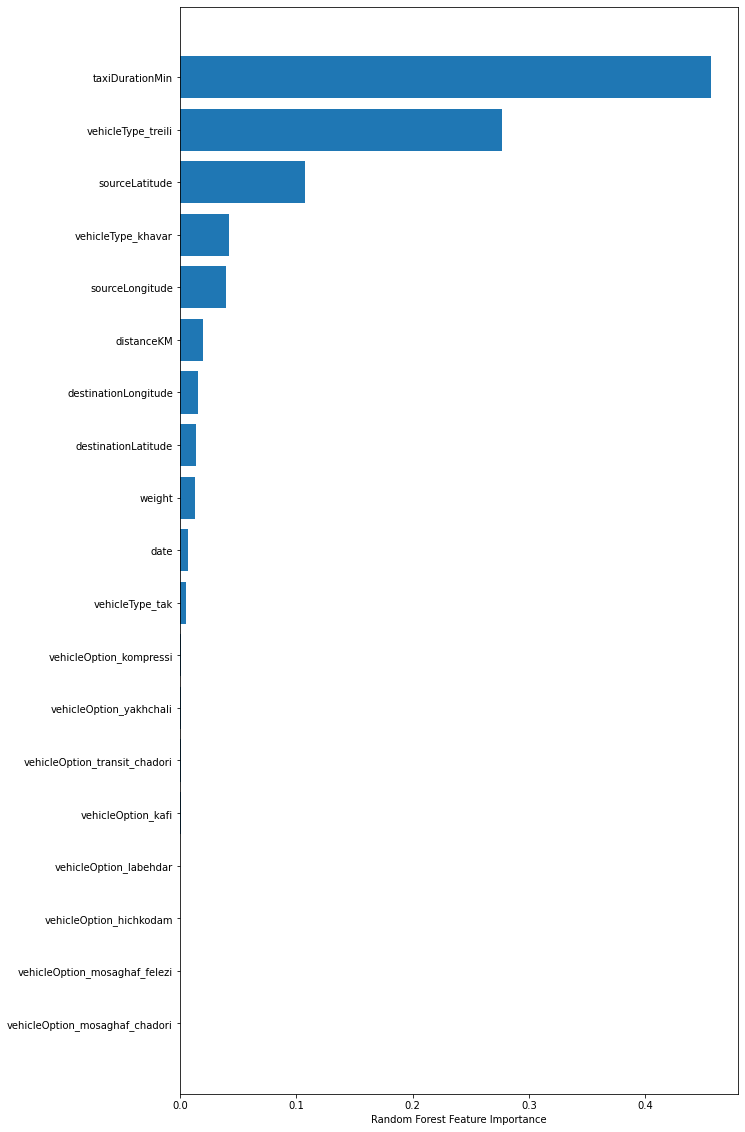

In [12]:
sorted_idx = model.feature_importances_.argsort()
plt.figure(figsize=(10,20))
plt.barh(features_columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

(0.0, 50000000.0)

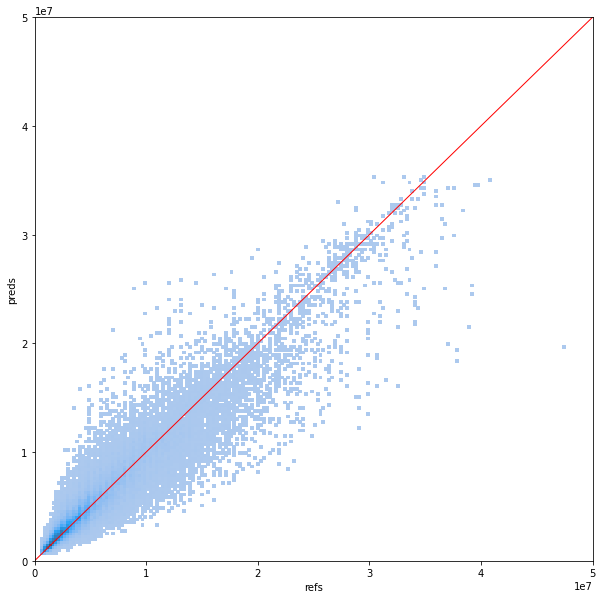

In [13]:
plt.figure(figsize=(10,10))
sns.histplot(data=results, x='refs', y='preds')
plt.plot([0, 50000000], [0, 50000000], linewidth=1, c='r')
plt.xlim([0, 50000000])
plt.ylim([0, 50000000])

# Error analysis

Error analysis is a crucial step in working on a model. We can check the performance of the model according to specific features 
to find the weakest aspect of the model.

In [14]:
data['refs'] = results['refs'].values
data['preds'] = results['preds'].values

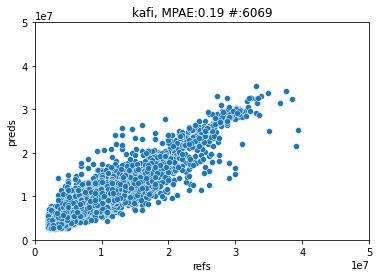

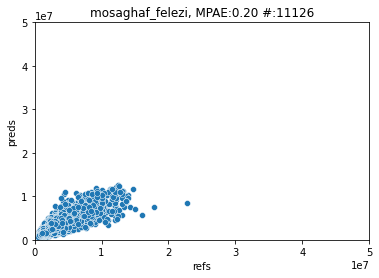

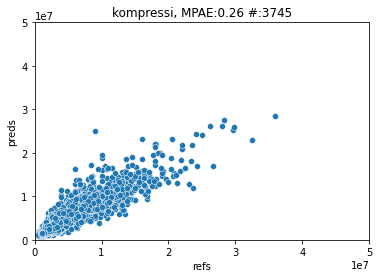

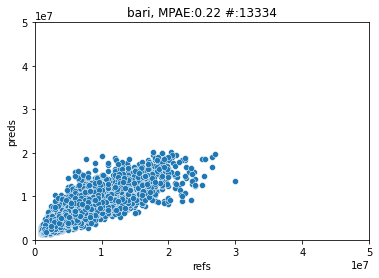

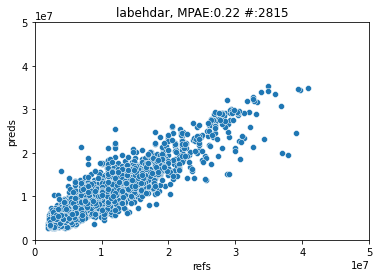

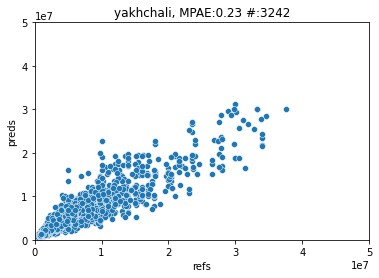

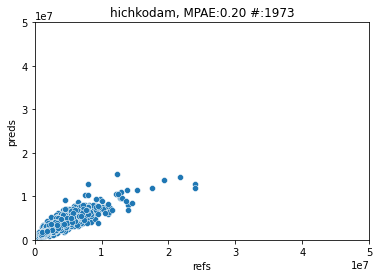

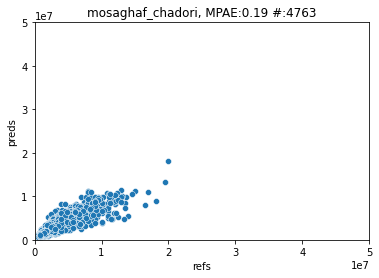

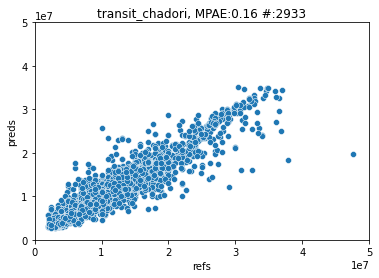

In [15]:
column = 'vehicleOption'

for vehicle_type in data[column].unique():
    tmp_data = data[data[column] == vehicle_type]
    title = f"{vehicle_type}, MPAE:{mean_absolute_percentage_error(tmp_data['refs'], tmp_data['preds']):.2f} #:{len(tmp_data)}"
    plt.title(title)
    sns.scatterplot(data=tmp_data, x='refs', y='preds')
    plt.xlim([0, 50000000])
    plt.ylim([0, 50000000])
    plt.show()

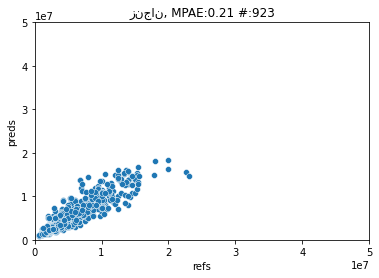

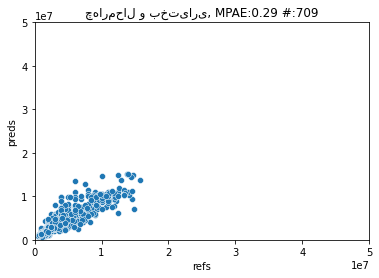

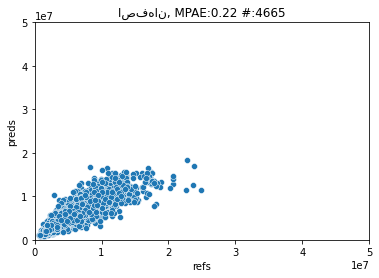

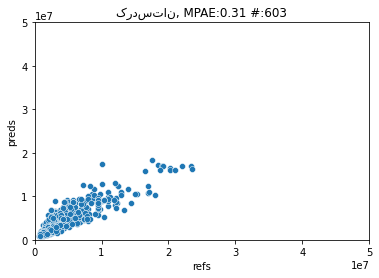

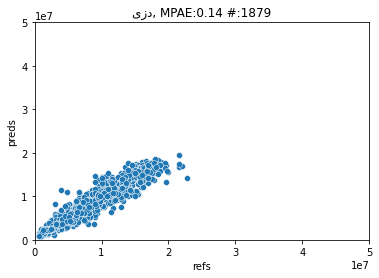

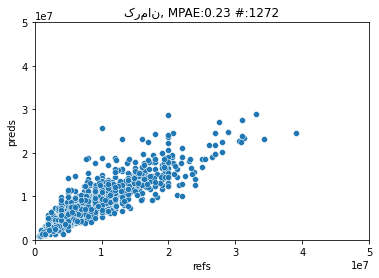

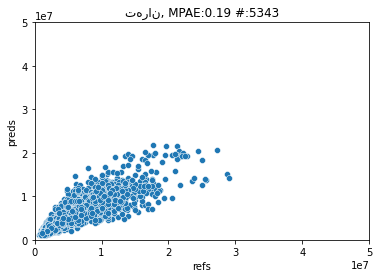

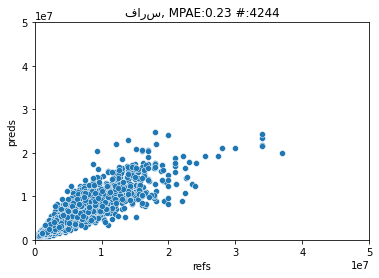

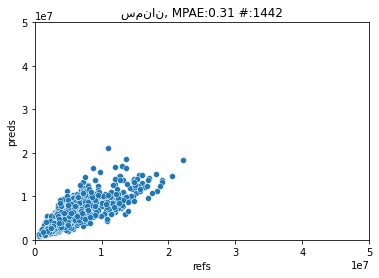

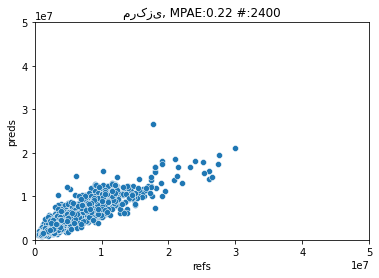

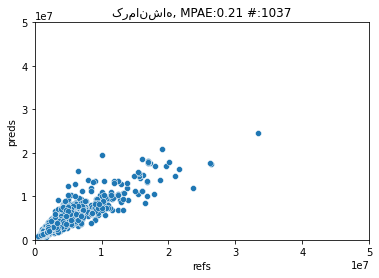

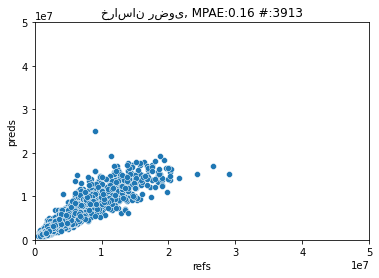

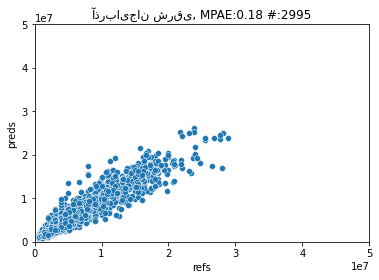

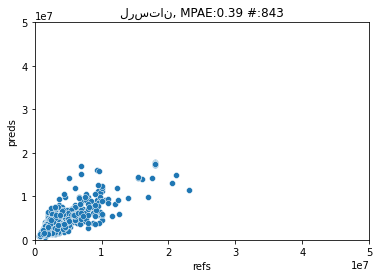

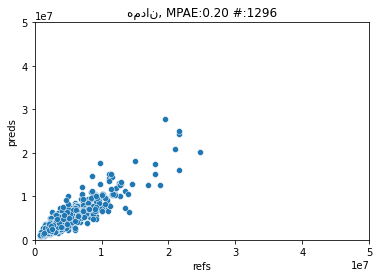

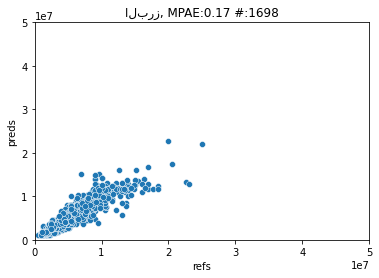

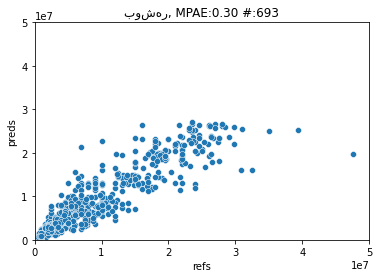

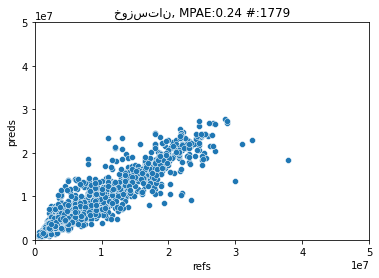

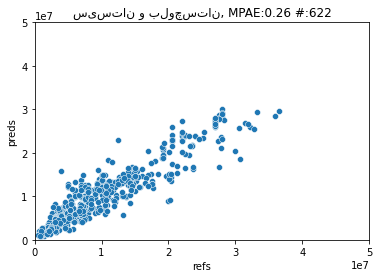

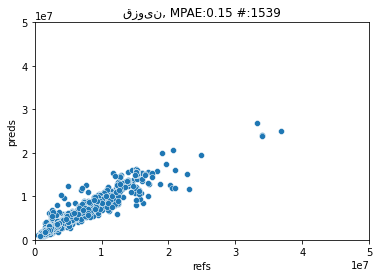

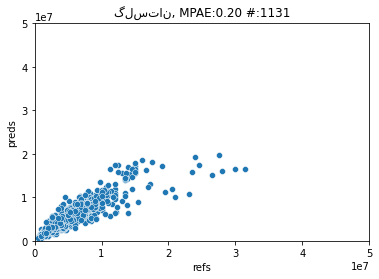

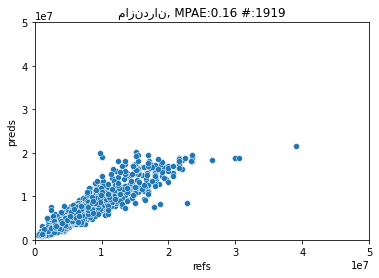

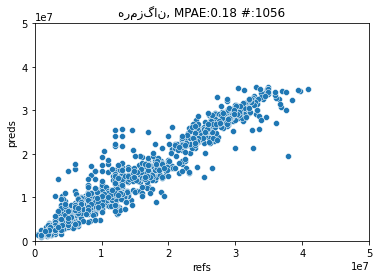

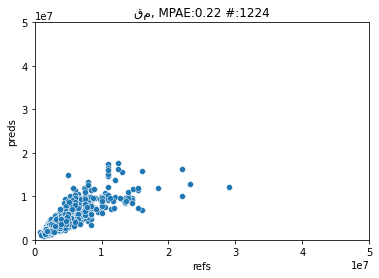

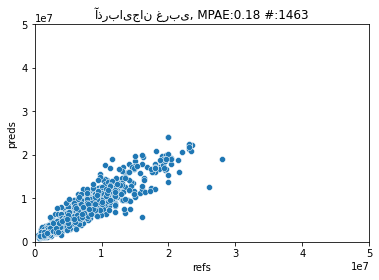

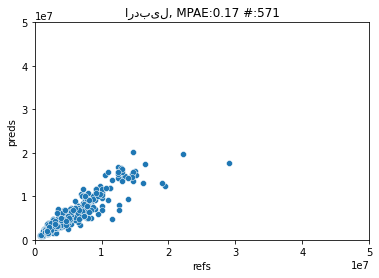

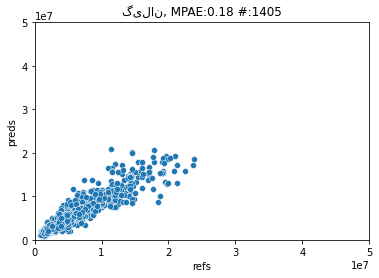

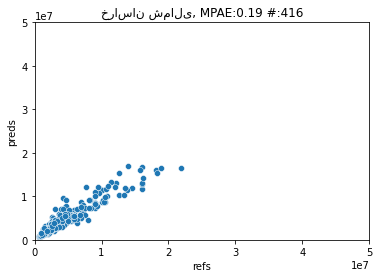

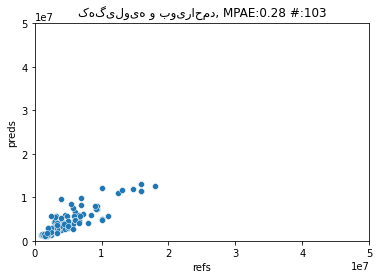

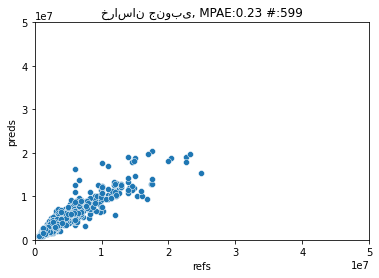

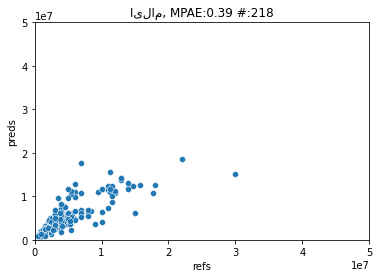

In [16]:
column = 'SourceState'

for vehicle_type in data[column].unique():
    tmp_data = data[data[column] == vehicle_type]
    title = f"{vehicle_type}, MPAE:{mean_absolute_percentage_error(tmp_data['refs'], tmp_data['preds']):.2f} #:{len(tmp_data)}"
    plt.title(title)
    sns.scatterplot(data=tmp_data, x='refs', y='preds')
    plt.xlim([0, 50000000])
    plt.ylim([0, 50000000])
    plt.show()